In [194]:
import numpy as np
from scipy.optimize import linprog
from pymprog import *
import networkx as nx
import matplotlib
%matplotlib inline

In [2]:
def draw_graph(G):
    nx_G = nx.from_dict_of_lists(G)
    nx.draw_networkx(nx_G)

# Linear Program for fractional clique number

Define a function to return all possible subsests for list of vertices V

In [3]:
def subsets(V, prefix=[], arr_sets=[]):
    if V == []: return
    for i in range(len(V)):
        subset = prefix + [V[i]]
        arr_sets += [subset]
        subsets(V[i+1:], subset, arr_sets)

In [4]:
def check_clique(graph, v_set):
    if len(v_set) < 2: return True
    for i in range(len(v_set)):
        i_set = set(v_set[:i] + v_set[i+1:])
        g_set = graph[v_set[i]]
        if i_set & g_set != i_set :
            return False
    return True

In [5]:
def A_clique_set(graph, v_encode, subsets, A=[]):
    for subset in subsets:
        if check_clique(graph, subset):
            A += [sum([v_encode[v] for v in subset])]

In [6]:
def lp_clique(graph):
    V = list(graph.keys())
    v_encode = {}
    v_num = len(V)
    
    for i in range(v_num):
        temp = np.zeros(v_num)
        temp[i] = -1
        v_encode[V[i]] = temp
    
    arr_sets = []
    subsets(V, arr_sets=arr_sets)
    
    b_clique = np.negative(np.ones(v_num))
    A_clique = []
    A_clique_set(graph, v_encode, arr_sets,A=A_clique)
    A_clique = np.transpose(np.array(A_clique))
    c_clique = np.ones(A_clique.shape[1])
    
    res = linprog(c_clique, A_ub=A_clique, b_ub=b_clique, bounds=(0, None))
    return res, A_clique

# Linear Program for Shannon entropy

In [7]:
def remove_unconnected_v(graph):
    keys = list(graph.keys())
    for v in keys:
        if len(graph[v]) == 0:
            graph.pop(v, None)

In [8]:
G10 = {1:set({}), 2:set({}), 3:set({}), 4:set({}), 5:set({}), 6:set({})}

In [9]:
remove_unconnected_v(G10)

In [10]:
G10

{}

In [11]:
def subsets_dict(V, prefix=[], arr_sets={}):
    if V == []: return 1
    for i in range(len(V)):
        subset = prefix + [V[i]]
        arr_sets[tuple(subset)] = len(arr_sets)
        subsets_dict(V[i+1:], subset, arr_sets)

In [12]:
def A_entropy_set(V, subsets_dict, A=[], b=[]):
    num_sets = len(subsets_dict)
    for subset in subsets_dict:
        subset_len = len(subset)
        subset_i = subsets_dict[subset]
        a_lq = np.zeros(num_sets)
        if subset_len > 1:
            a_lq[subset_i] = -1 * (subset_len)
            a_mq = np.zeros(num_sets)
            a_mq[subset_i] = subset_len - 1
            s = set(subset)
            for v in subset:
                sub_i = subsets_dict[tuple(x for x in subset if v != x)]
                a_lq[sub_i] = 1    
                a_mq[sub_i] = -1
            A += [a_lq, a_mq]
            b += [0, 0]
        else:
            a_lq[subset_i] = 1
            A += [a_lq]
            b += [1]

In [13]:
def A_entropy_set_2(V, subsets_dict, A=[], b=[]):
    num_sets = len(subsets_dict)
    subsets = list(subsets_dict.keys())
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = subsets_dict[subset_i]
        for j in range(i, num_sets):
            subset_j = subsets[j]
            pos_j = subsets_dict[subset_j]
            a_lq = np.zeros(num_sets)
            if len(subset_i) < 2 and pos_i == pos_j: 
                a_lq[pos_i] = 1
                A += [a_lq]
                b += [1]
#                 print("identical", subset_i)
            else:
                a_mq = np.zeros(num_sets)
                subset_i = set(subset_i)
                subset_j = set(subset_j)
                subset_ij_u = subset_i | subset_j
                subset_ij_i = subset_i & subset_j
                if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                    if len(subset_i) > len(subset_j):
                        a_mq[pos_i] = -1
                        a_mq[pos_j] = 1
                        A += [a_mq]
                        b += [0]
                    elif len(subset_i) < len(subset_j):
                        a_mq[pos_i] = 1
                        a_mq[pos_j] = -1
                        A += [a_mq]
                        b += [0]
#                     print("intersect each other", subset_i, subset_j)
                else:
#                     print("not intersection of each other", subset_i, subset_j)
                    a_lq[pos_i] = -1
                    a_lq[pos_j] = -1
                    a_lq[subsets_dict[tuple(subset_ij_u)]] = 1
                    if len(subset_ij_i) > 0:
                        a_lq[subsets_dict[tuple(subset_ij_i)]] = 1
                    A += [a_lq]
                    b += [0]

This version is missing a lot of important conditions

In [14]:
def A_entropy_set_3(V, subsets_dict, A=[], b=[]):
    num_sets = len(subsets_dict)
    subsets = list(subsets_dict.keys())
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = subsets_dict[subset_i]
        for j in range(i, num_sets):
            subset_j = subsets[j]
            pos_j = subsets_dict[subset_j]
            a_mq = np.zeros(num_sets)
            if len(subset_i) < 2 and pos_i == pos_j: 
                a_mq[pos_i] = 1
                A += [a_mq]
                b += [1]
            else:
                subset_i = set(subset_i)
                subset_j = set(subset_j)
                subset_ij_u = subset_i | subset_j
                subset_ij_i = subset_i & subset_j
                if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                    if len(subset_i) > len(subset_j):
                        a_mq[pos_i] = -1
                        a_mq[pos_j] = 1
                        A += [a_mq]
                        b += [0]
                    elif len(subset_i) < len(subset_j):
                        a_mq[pos_i] = 1
                        a_mq[pos_j] = -1
                        A += [a_mq]
                        b += [0]
        
        if len(subset_i) > 1:
            a_lq = np.zeros(num_sets)
            a_lq[pos_i] = 1
            for v in subset_i:
                sub_i = subsets_dict[(v,)]
                a_lq[sub_i] = -1
            A += [a_lq]
            b += [0]


In [15]:
def entropy_eq_dict(graph, eq_dict={}):
    for v in graph:
        n = tuple(graph[v])
        n_v = tuple(graph[v] | {v})
        if n in eq_dict:
            eq_dict[n_v] = eq_dict[n]
        else:
            eq_dict[n] = n_v    

In [81]:
def A_entropy_set_4(graph, subsets_dict, eq_dict,  A=[]):
    num_sets = len(subsets_dict)
    subsets = list(subsets_dict.keys())
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = subsets_dict[subset_i]
        rep_i = subset_i in eq_dict
        for j in range(i + 1, num_sets):
            subset_j = subsets[j]
            pos_j = subsets_dict[subset_j]
            rep_j = subset_j in eq_dict            
            
            val_i, val_j = (), ()
            
            if rep_i:
                pos_i = subsets_dict[eq_dict[subset_i]]
            if rep_j:
                pos_j = subsets_dict[eq_dict[subset_j]]

            subset_i_s = set(subset_i)
            subset_j_s = set(subset_j)
            subset_ij_u = tuple(subset_i_s | subset_j_s)
            subset_ij_i = tuple(subset_i_s & subset_j_s)
            
            pos_u = subsets_dict[subset_ij_u]
            
            if subset_ij_u in eq_dict:
                pos_u = subsets_dict[eq_dict[subset_ij_u]]
            
            if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                if pos_i == pos_j: 
#                     print('skipped mq same pos', subset_i, subset_j, subset_ij_u, subset_ij_i, pos_i, pos_j)
                    continue
                diff = len(subset_i) - len(subset_j)
                a_mq = np.zeros(num_sets) 
                if diff == 1:
                    a_mq[pos_i] = -1
                    a_mq[pos_j] = 1
                    A += [a_mq]
#                     print('mq', subset_i, subset_j, subset_ij_u, subset_ij_i, pos_i, pos_j, a_mq)
                elif diff == -1:
                    a_mq[pos_i] = 1
                    a_mq[pos_j] = -1
                    A += [a_mq]
#                     print('mq', subset_i, subset_j, subset_ij_u, subset_ij_i, pos_i, pos_j, a_mq)
            else:
                if ((pos_i == pos_u and pos_j != pos_u) or 
                (pos_j == pos_u and pos_i != pos_u)): 
#                     print('skipped lq', subset_i, subset_j, subset_ij_u, subset_ij_i, pos_i, pos_j)
                    continue
                a_lq = np.zeros(num_sets) 
                
                a_lq[pos_i] = -1
                a_lq[pos_j] = -1
                
                if pos_i == pos_j == pos_u:
                    continue
                    a_lq[pos_u] = -1
                else:
                    a_lq[pos_u] = 1
                
                if len(subset_ij_i) > 0:
                    if subset_ij_i in eq_dict:
                        pos_ij = subsets_dict[eq_dict[subset_ij_i]]
                        if pos_i != pos_j:
                            if pos_i == pos_ij:
                                a_lq[pos_i] = 0
                            elif pos_j == pos_ij:
                                a_lq[pos_j] = 0
                            else:
                                a_lq[pos_ij] = 1
                    else:
                        pos_ij = subsets_dict[subset_ij_i]
                        a_lq[pos_ij] = 1
                A += [a_lq]
#                 print('lq', subset_i, subset_j, subset_ij_u, subset_ij_i, pos_i, pos_j, a_lq)

In [ ]:
def A_entropy_set_5(graph, subsets_dict, eq_dict,  A=[]):
    num_sets = len(subsets_dict)
    subsets = list(subsets_dict.keys())
    
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = arr_sets[subset_i]
        rep_i = subset_i in eq_dict
        for j in range(i + 1, num_sets):
            subset_j = subsets[j]
            pos_j = arr_sets[subset_j]
            rep_j = subset_j in eq_dict            
                        
            if rep_i:
                pos_i = arr_sets[eq_dict[subset_i]]
            if rep_j:
                pos_j = arr_sets[eq_dict[subset_j]]

            subset_i_s = set(subset_i)
            subset_j_s = set(subset_j)
            subset_ij_u = tuple(subset_i_s | subset_j_s)
            subset_ij_i = tuple(subset_i_s & subset_j_s)
            
            pos_u = arr_sets[subset_ij_u]
            
            if subset_ij_u in eq_dict:
                pos_u = arr_sets[eq_dict[subset_ij_u]]
            
            if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                if pos_i == pos_j: 
                    continue
                a_mq = np.zeros(num_sets) 
                diff = len(subset_i) - len(subset_j)
                if diff == 1:
                    print('mq', subset_i, subset_j)
                    a_mq[pos_i] = -1
                    a_mq[pos_j] = 1
                    A += [a_mq]
                elif diff == -1:
                    print('mq', subset_j, subset_i)
                    a_mq[pos_i] = 1
                    a_mq[pos_j] = -1
                    A += [a_mq]
            else:
                if ((pos_i == pos_u and pos_j != pos_u) or 
                (pos_j == pos_u and pos_i != pos_u)): 
                    continue
                
                a_lq = np.zeros(num_sets) 
                
                if len(subset_ij_i) > 0:
                    pos_ij = arr_sets[subset_ij_i]

                    if subset_ij_i in eq_dict:
                        pos_ij = arr_sets[eq_dict[subset_ij_i]]
                    
                    if pos_i == pos_j == pos_u:
                        print('lq', subset_i, subset_j, subset_ij_u, subset_ij_i)
                        a_lq[pos_i] = 1
                        a_lq[pos_ij] = -1
                    elif pos_i != pos_j:
                        if pos_i == pos_ij:
                            print('lq', subset_i, subset_j, subset_ij_u, subset_ij_i)
                            a_lq[pos_u] = 1
                            a_lq[pos_j] = -1
                        elif pos_j == pos_ij:
                            print('lq', subset_i, subset_j, subset_ij_u, subset_ij_i)
                            a_lq[pos_u] = 1
                            a_lq[pos_i] = -1
                        else:
                            print('lq', subset_i, subset_j, subset_ij_u, subset_ij_i)
                            a_lq[pos_u] = 1
                            a_lq[pos_ij] = 1
                            a_lq[pos_i] = -1
                            a_lq[pos_j] = -1
                else:
                    if pos_i == pos_j == pos_u:
                        continue
                    else:
                        print('lq', subset_i, subset_j, subset_ij_u, subset_ij_i)
                        a_lq[pos_u] = 1
                        a_lq[pos_i] = -1
                        a_lq[pos_j] = -1
                
                A += [a_lq]

In [180]:
def A_entropy_set_6(graph, subsets_dict, eq_dict,  A=[]):
    num_sets = len(subsets_dict)
    subsets = list(subsets_dict.keys())
    
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = arr_sets[subset_i]
        rep_i = subset_i in eq_dict
        for j in range(i + 1, num_sets):
            subset_j = subsets[j]
            pos_j = arr_sets[subset_j]
            rep_j = subset_j in eq_dict            
                        
            if rep_i:
                pos_i = arr_sets[eq_dict[subset_i]]
            if rep_j:
                pos_j = arr_sets[eq_dict[subset_j]]

            subset_i_s = set(subset_i)
            subset_j_s = set(subset_j)
            subset_ij_u = tuple(subset_i_s | subset_j_s)
            subset_ij_i = tuple(subset_i_s & subset_j_s)
            
            pos_u = arr_sets[subset_ij_u]
            
            if subset_ij_u in eq_dict:
                pos_u = arr_sets[eq_dict[subset_ij_u]]
            
            if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                if pos_i == pos_j: 
                    continue
                a_mq = np.zeros(num_sets) 
                diff = len(subset_i) - len(subset_j)
                if diff == 1:
                    print('mq', subset_i, subset_j)
                    a_mq[pos_i] = -1
                    a_mq[pos_j] = 1
                    A += [a_mq]
                elif diff == -1:
                    print('mq', subset_j, subset_i)
                    a_mq[pos_i] = 1
                    a_mq[pos_j] = -1
                    A += [a_mq]
            else:
                if ((pos_i == pos_u and pos_j != pos_u) or 
                (pos_j == pos_u and pos_i != pos_u)): 
                    continue
                
                a_lq = np.zeros(num_sets) 
                
                if len(subset_ij_i) > 0:
                    pos_ij = arr_sets[subset_ij_i]

                    if subset_ij_i in eq_dict:
                        pos_ij = arr_sets[eq_dict[subset_ij_i]]
                    
                    if pos_i == pos_j == pos_u:
                        continue
                    elif pos_i != pos_j:
                        if pos_i == pos_ij:
                            continue
                            print('lq', subset_i, subset_j, subset_ij_u, subset_ij_i)
                            a_lq[pos_u] = 1
                            a_lq[pos_j] = -1
                        elif pos_j == pos_ij:
                            continue
                            print('lq', subset_i, subset_j, subset_ij_u, subset_ij_i)
                            a_lq[pos_u] = 1
                            a_lq[pos_i] = -1
                        else:
                            print('lq', subset_i, subset_j, subset_ij_u, subset_ij_i)
                            a_lq[pos_u] = 1
                            a_lq[pos_ij] = 1
                            a_lq[pos_i] = -1
                            a_lq[pos_j] = -1
                            A += [a_lq]
                else:
                    if pos_i == pos_j == pos_u:
                        continue
                    else:
                        continue
                        print('lq', subset_i, subset_j, subset_ij_u, subset_ij_i)
                        a_lq[pos_u] = 1
                        a_lq[pos_i] = -1
                        a_lq[pos_j] = -1
                        A += [a_lq]
                
#                 A += [a_lq]

In [181]:
def A_entropy_eq_set(graph, subsets_dict, A=[]):
    num_sets = len(subsets_dict)
    for v in graph:
        n = tuple(graph[v])
        n_v = tuple(graph[v] | {v})
        a_eq = np.zeros(num_sets)
        a_eq[subsets_dict[n_v]] = 1
        if len(n) > 0: 
            a_eq[subsets_dict[n]] = -1
        A += [a_eq]

In [182]:
def A_entropy_eq_set_2(subsets_dict, eq_dict, A=[]):
    num_sets = len(subsets_dict)
    for k in eq_dict:
        v = eq_dict[k]
        a_eq = np.zeros(num_sets)
        a_eq[subsets_dict[k]] = 1
        a_eq[subsets_dict[v]] = -1
        A += [a_eq]

In [183]:
def remove_duplicate_A(A=np.array([])):
    temp_a = np.ascontiguousarray(A)
    unique_a = np.unique(temp_a.view([('', temp_a.dtype)]*temp_a.shape[1]))
    A = unique_a.view(temp_a.dtype).reshape((unique_a.shape[0], temp_a.shape[1]))
    return A

In [184]:
def add_v_Ab(V, subsets_dict, A=np.array([]), b=np.array([])):
    A = list(A)
    b = b.tolist()
    print(len(A))
    num_sets = len(subsets_dict)
    for _v in V:
        pos_v = subsets_dict[(_v,)]
        temp_a = np.zeros(num_sets)
        temp_a[pos_v] = 1
        A += [temp_a]
        b += [1]
    return np.array(A), np.array(b)

In [185]:
def lp_entropy_1(graph):
    # remove all isolated vertices from the graph
    remove_unconnected_v(graph)
        
    V = list(graph.keys())
    v_num = len(V)
    
    if v_num == 0: return 0
    
    arr_sets = {}
    subsets_dict(V, arr_sets=arr_sets)
    
    eq_dict = {}
    entropy_eq_dict(graph, eq_dict=eq_dict)
    
    A_entropy = []
    b_entropy = []
    A_entropy_set_2(graph, arr_sets, A=A_entropy, b=b_entropy)
    A_entropy = np.array(A_entropy)
    b_entropy = np.array(b_entropy, dtype=float)
    
    A_entropy_eq = []
    A_entropy_eq_set(graph, arr_sets, A=A_entropy_eq)
    A_entropy_eq = np.array(A_entropy_eq)
    b_entropy_eq = np.zeros(A_entropy_eq.shape[0])
    
    c_clique = np.zeros(len(arr_sets))
    c_clique[arr_sets[tuple(V)]] = -1
    
    print(A_entropy, A_entropy.shape)
    
    res = linprog(c_clique, A_ub=A_entropy, b_ub=b_entropy, A_eq=A_entropy_eq, b_eq=b_entropy_eq, bounds=(0, None))
    
    x = res.x
    keys = list(arr_sets.keys())
    for i in range(x.shape[0]):
        print(keys[i], x[i])
    return res

In [188]:
def lp_entropy(graph):
    # remove all isolated vertices from the graph
    remove_unconnected_v(graph)
        
    V = list(graph.keys())
    v_num = len(V)
    
    if v_num == 0: return 0
    
    arr_sets = {}
    subsets_dict(V, arr_sets=arr_sets)
    
    eq_dict = {}
    entropy_eq_dict(graph, eq_dict=eq_dict)
    
    print(eq_dict)
    
    A_entropy = []
    A_entropy_set_4(graph, arr_sets, eq_dict, A=A_entropy)
    A_entropy = np.array(A_entropy)
    print(A_entropy, A_entropy.shape)
    
    A_entropy = remove_duplicate_A(A=A_entropy)
    b_entropy = np.zeros(A_entropy.shape[0])
    
    print(A_entropy, A_entropy.shape)
    A_entropy, b_entropy = add_v_Ab(V, arr_sets, A=A_entropy, b=b_entropy)
    
    A_entropy_eq = []
    A_entropy_eq_set_2(arr_sets, eq_dict, A=A_entropy_eq)
    A_entropy_eq = np.array(A_entropy_eq)
    b_entropy_eq = np.zeros(A_entropy_eq.shape[0])
    
    c_clique = np.zeros(len(arr_sets))
    c_clique[arr_sets[tuple(V)]] = -1
    
    print(A_entropy, A_entropy.shape)
    
    res = linprog(c_clique, A_ub=A_entropy, b_ub=b_entropy, A_eq=A_entropy_eq, b_eq=b_entropy_eq, bounds=(0, None), options={'maxiter':1e6, 'tol':1e-6})
    
    x = res.x
    keys = list(arr_sets.keys())
    for i in range(x.shape[0]):
        print(keys[i], x[i])
    return res

In [195]:
def lp_entropy_2(graph):
    # remove all isolated vertices from the graph
    remove_unconnected_v(graph)
        
    V = list(graph.keys())
    v_num = len(V)
    
    if v_num == 0: return 0
    
    arr_sets = {}
    subsets_dict(V, arr_sets=arr_sets)
    
    eq_dict = {}
    entropy_eq_dict(graph, eq_dict=eq_dict)
    
    print(eq_dict)
    
    p = begin('shannon entropy')
    
    p.verbose(True) 
    
    num_sets = len(arr_sets)
    subsets = list(arr_sets.keys())
    
    x = p.var('x', num_sets)
    
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = arr_sets[subset_i]
        rep_i = subset_i in eq_dict
        if len(subset_i) < 2:
            x[pos_i] <= 1
        for j in range(i + 1, num_sets):
            subset_j = subsets[j]
            pos_j = arr_sets[subset_j]
            rep_j = subset_j in eq_dict            
                        
            if rep_i:
                pos_i = arr_sets[eq_dict[subset_i]]
            if rep_j:
                pos_j = arr_sets[eq_dict[subset_j]]

            subset_i_s = set(subset_i)
            subset_j_s = set(subset_j)
            subset_ij_u = tuple(subset_i_s | subset_j_s)
            subset_ij_i = tuple(subset_i_s & subset_j_s)
            
            pos_u = arr_sets[subset_ij_u]
            
            if subset_ij_u in eq_dict:
                pos_u = arr_sets[eq_dict[subset_ij_u]]
            
            if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                if pos_i == pos_j: 
                    continue
                diff = len(subset_i) - len(subset_j)
                if diff == 1:
                    x[pos_j] <= x[pos_i]
                elif diff == -1:
                    x[pos_i] <= x[pos_j]
            else:
                if ((pos_i == pos_u and pos_j != pos_u) or 
                (pos_j == pos_u and pos_i != pos_u)): 
                    continue
                        
                if len(subset_ij_i) > 0:
                    pos_ij = arr_sets[subset_ij_i]

                    if subset_ij_i in eq_dict:
                        pos_ij = arr_sets[eq_dict[subset_ij_i]]
                                     
                        if pos_i != pos_j:
                            if pos_i == pos_ij:
                                x[pos_u] <= x[pos_j]
                            elif pos_j == pos_ij:
                                x[pos_u] <= x[pos_i]
                            else:
                                x[pos_u] + x[pos_ij] - x[pos_i] - x[pos_j] <= 0
                    else:
                        x[pos_u] + x[pos_ij] - x[pos_i] - x[pos_j] <= 0
                else:
                    if pos_i == pos_j == pos_u:
                        continue
                    else:
                        x[pos_u] - x[pos_i] - x[pos_j] <= 0
                    
    for k in eq_dict:
        pos_i = arr_sets[k]
        pos_j = arr_sets[eq_dict[k]]
        x[pos_i] == x[pos_j]
        
    p.maximize(x[arr_sets[tuple(V)]], 'x_v')
    
    p.solve()
    
    print("###>Objective value: %f"%p.vobj())
        
    p.sensitivity() 
    
    p.end()

# Sample Graphs

In [196]:
G1 = {1:{2,5,6}, 2:{1,3,6}, 3:{2,4}, 4:{3,5,7}, 5:{1,4}, 6:{1,2,7}, 7:{4,6}}
G2 = {1:{2,5,6}, 2:{1,3,7}, 3:{2,4,6}, 4:{3,5}, 5:{1,4}, 6:{1,3,7}, 7:{2,6}}
G3 = {1:{2,5,6}, 2:{1,3}, 3:{2,4,6}, 4:{3,5,7}, 5:{1,4}, 6:{1,3,7}, 7:{4,6}}
G4 = {1:{2,5,6}, 2:{1,3,7}, 3:{2,4,6}, 4:{3,5,7}, 5:{1,4}, 6:{1,3,7}, 7:{2,4,6}}
G5 = {1:{2,5,6}, 2:{1,3,7}, 3:{2,4}, 4:{3,5}, 5:{1,4}, 6:{1,7}, 7:{2,6}}
G6 = {1:{2,5,6}, 2:{1,3}, 3:{2,4,7}, 4:{3,5}, 5:{1,4}, 6:{1,7}, 7:{3,6}}
G7 = {1:{2,3,4,5,6,7}, 2:{1,3,4,5,6,7}, 3:{1,2,4,5,6,7}, 4:{1,2,3,5,6,7}, 5:{1,2,3,4,6,7}, 6:{1,2,3,4,5,7}, 7:{1,2,3,4,5,6}}

In [197]:
lp_entropy_2(G1)

{(2, 5, 6): (1, 2, 5, 6), (1, 3, 6): (1, 2, 3, 6), (2, 4): (2, 3, 4), (3, 5, 7): (3, 4, 5, 7), (1, 4): (1, 4, 5), (1, 2, 7): (1, 2, 6, 7), (4, 6): (4, 6, 7)}
single value
mq (1, 2) (1,)
R1: x[0] - x[1] <= 0
mq (1, 3) (1,)
R2: x[0] - x[33] <= 0
mq (1, 4) (1,)
R3: x[0] - x[50] <= 0
mq (1, 5) (1,)
R4: x[0] - x[57] <= 0
mq (1, 6) (1,)
R5: x[0] - x[61] <= 0
mq (1, 7) (1,)
R6: x[0] - x[63] <= 0
lq (1,) (2,) (1, 2) ()
R7: x[1] - x[0] - x[64] <= 0
lq (1,) (2, 3) (1, 2, 3) ()
R8: x[2] - x[0] - x[65] <= 0
lq (1,) (2, 3, 4) (1, 2, 3, 4) ()
R9: x[3] - x[0] - x[66] <= 0
lq (1,) (2, 3, 4, 5) (1, 2, 3, 4, 5) ()
R10: x[4] - x[0] - x[67] <= 0
lq (1,) (2, 3, 4, 5, 6) (1, 2, 3, 4, 5, 6) ()
R11: x[5] - x[0] - x[68] <= 0
lq (1,) (2, 3, 4, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) ()
R12: x[6] - x[0] - x[69] <= 0
lq (1,) (2, 3, 4, 5, 7) (1, 2, 3, 4, 5, 7) ()
R13: x[7] - x[0] - x[70] <= 0
lq (1,) (2, 3, 4, 6) (1, 2, 3, 4, 6) ()
R14: x[8] - x[0] - x[71] <= 0
lq (1,) (2, 3, 4, 6, 7) (1, 2, 3, 4, 6, 7) ()
R15: x[9] - x[0]

lq (1, 2, 3, 4) (2, 3, 5, 6) (1, 2, 3, 4, 5, 6) (2, 3)
R339: x[5] + x[65] - x[3] - x[75] <= 0
lq (1, 2, 3, 4) (2, 3, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) (2, 3)
R340: x[6] + x[65] - x[3] - x[76] <= 0
lq (1, 2, 3, 4) (2, 3, 5, 7) (1, 2, 3, 4, 5, 7) (2, 3)
R341: x[7] + x[65] - x[3] - x[77] <= 0
lq (1, 2, 3, 4) (2, 3, 6) (1, 2, 3, 4, 6) (2, 3)
R342: x[8] + x[65] - x[3] - x[78] <= 0
lq (1, 2, 3, 4) (2, 3, 6, 7) (1, 2, 3, 4, 6, 7) (2, 3)
R343: x[9] + x[65] - x[3] - x[79] <= 0
lq (1, 2, 3, 4) (2, 3, 7) (1, 2, 3, 4, 7) (2, 3)
R344: x[10] + x[65] - x[3] - x[80] <= 0
lq (1, 2, 3, 4) (2, 4, 5) (1, 2, 3, 4, 5) (2, 4)
R345: x[4] + x[66] - x[3] - x[82] <= 0
lq (1, 2, 3, 4) (2, 4, 5, 6) (1, 2, 3, 4, 5, 6) (2, 4)
R346: x[5] + x[66] - x[3] - x[83] <= 0
lq (1, 2, 3, 4) (2, 4, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) (2, 4)
R347: x[6] + x[66] - x[3] - x[84] <= 0
lq (1, 2, 3, 4) (2, 4, 5, 7) (1, 2, 3, 4, 5, 7) (2, 4)
R348: x[7] + x[66] - x[3] - x[85] <= 0
lq (1, 2, 3, 4) (2, 4, 6) (1, 2, 3, 4, 6) (2, 4)
R349: x[8] + x[6

R514: x[6] + x[51] - x[5] - x[52] <= 0
lq (1, 2, 3, 4, 5, 6) (1, 4, 5, 7) (1, 2, 3, 4, 5, 6, 7) (1, 4, 5)
R515: x[6] + x[50] - x[5] - x[53] <= 0
lq (1, 2, 3, 4, 5, 6) (1, 4, 6, 7) (1, 2, 3, 4, 5, 6, 7) (1, 4, 6)
R516: x[6] + x[54] - x[5] - x[55] <= 0
lq (1, 2, 3, 4, 5, 6) (1, 4, 7) (1, 2, 3, 4, 5, 6, 7) (1, 4)
R517: x[6] + x[50] - x[5] - x[56] <= 0
lq (1, 2, 3, 4, 5, 6) (1, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) (1, 5, 6)
R518: x[6] + x[58] - x[5] - x[59] <= 0
lq (1, 2, 3, 4, 5, 6) (1, 5, 7) (1, 2, 3, 4, 5, 6, 7) (1, 5)
R519: x[6] + x[57] - x[5] - x[60] <= 0
lq (1, 2, 3, 4, 5, 6) (1, 6, 7) (1, 2, 3, 4, 5, 6, 7) (1, 6)
R520: x[6] + x[61] - x[5] - x[62] <= 0
lq (1, 2, 3, 4, 5, 6) (1, 7) (1, 2, 3, 4, 5, 6, 7) (1,)
R521: x[6] + x[0] - x[5] - x[63] <= 0
mq (1, 2, 3, 4, 5, 6) (2, 3, 4, 5, 6)
R522: x[68] - x[5] <= 0
lq (1, 2, 3, 4, 5, 6) (2, 3, 4, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) (2, 3, 4, 5, 6)
R523: x[6] + x[68] - x[5] - x[69] <= 0
lq (1, 2, 3, 4, 5, 6) (2, 3, 4, 5, 7) (1, 2, 3, 4, 5, 6, 7) (2, 3, 4,

lq (1, 2, 3, 4, 6, 7) (2, 5, 7) (1, 2, 3, 4, 5, 6, 7) (2, 7)
R772: x[6] + x[95] - x[9] - x[92] <= 0
lq (1, 2, 3, 4, 6, 7) (3, 4, 5) (1, 2, 3, 4, 5, 6, 7) (3, 4)
R773: x[6] + x[97] - x[9] - x[98] <= 0
lq (1, 2, 3, 4, 6, 7) (3, 4, 5, 6) (1, 2, 3, 4, 5, 6, 7) (3, 4, 6)
R774: x[6] + x[102] - x[9] - x[99] <= 0
lq (1, 2, 3, 4, 6, 7) (3, 4, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) (3, 4, 6, 7)
R775: x[6] + x[103] - x[9] - x[100] <= 0
lq (1, 2, 3, 4, 6, 7) (3, 4, 5, 7) (1, 2, 3, 4, 5, 6, 7) (3, 4, 7)
R776: x[6] + x[104] - x[9] - x[101] <= 0
lq (1, 2, 3, 4, 6, 7) (3, 5) (1, 2, 3, 4, 5, 6, 7) (3,)
R777: x[6] + x[96] - x[9] - x[105] <= 0
lq (1, 2, 3, 4, 6, 7) (3, 5, 6) (1, 2, 3, 4, 5, 6, 7) (3, 6)
R778: x[6] + x[109] - x[9] - x[106] <= 0
lq (1, 2, 3, 4, 6, 7) (3, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) (3, 6, 7)
R779: x[6] + x[110] - x[9] - x[107] <= 0
lq (1, 2, 3, 4, 6, 7) (3, 5, 7) (1, 2, 3, 4, 5, 6, 7) (3, 7)
R780: x[6] + x[111] - x[9] - x[101] <= 0
lq (1, 2, 3, 4, 6, 7) (4, 5) (1, 2, 3, 4, 5, 6, 7) (4,)
R781: x

lq (1, 2, 3, 5, 6) (2, 4, 6, 7) (1, 2, 3, 4, 5, 6, 7) (2, 6)
R1051: x[6] + x[93] - x[12] - x[87] <= 0
lq (1, 2, 3, 5, 6) (2, 4, 7) (1, 2, 3, 4, 5, 6, 7) (2,)
R1052: x[6] + x[64] - x[12] - x[88] <= 0
lq (1, 2, 3, 5, 6) (2, 5, 6, 7) (1, 2, 3, 5, 6, 7) (2, 5, 6)
R1053: x[13] + x[27] - x[12] - x[91] <= 0
lq (1, 2, 3, 5, 6) (2, 5, 7) (1, 2, 3, 5, 6, 7) (2, 5)
R1054: x[13] + x[89] - x[12] - x[92] <= 0
lq (1, 2, 3, 5, 6) (2, 6, 7) (1, 2, 3, 5, 6, 7) (2, 6)
R1055: x[13] + x[93] - x[12] - x[94] <= 0
lq (1, 2, 3, 5, 6) (2, 7) (1, 2, 3, 5, 6, 7) (2,)
R1056: x[13] + x[64] - x[12] - x[95] <= 0
lq (1, 2, 3, 5, 6) (3, 4) (1, 2, 3, 4, 5, 6) (3,)
R1057: x[5] + x[96] - x[12] - x[97] <= 0
lq (1, 2, 3, 5, 6) (3, 4, 5) (1, 2, 3, 4, 5, 6) (3, 5)
R1058: x[5] + x[105] - x[12] - x[98] <= 0
lq (1, 2, 3, 5, 6) (3, 4, 5, 6) (1, 2, 3, 4, 5, 6) (3, 5, 6)
R1059: x[5] + x[106] - x[12] - x[99] <= 0
lq (1, 2, 3, 5, 6) (3, 4, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) (3, 5, 6)
R1060: x[6] + x[106] - x[12] - x[100] <= 0
lq (1, 2, 3

lq (1, 2, 3, 6) (3, 5, 6) (1, 2, 3, 5, 6) (3, 6)
R1315: x[12] + x[109] - x[15] - x[106] <= 0
lq (1, 2, 3, 6) (3, 5, 6, 7) (1, 2, 3, 5, 6, 7) (3, 6)
R1316: x[13] + x[109] - x[15] - x[107] <= 0
lq (1, 2, 3, 6) (3, 5, 7) (1, 2, 3, 5, 6, 7) (3,)
R1317: x[13] + x[96] - x[15] - x[101] <= 0
lq (1, 2, 3, 6) (3, 6, 7) (1, 2, 3, 6, 7) (3, 6)
R1318: x[16] + x[109] - x[15] - x[110] <= 0
lq (1, 2, 3, 6) (3, 7) (1, 2, 3, 6, 7) (3,)
R1319: x[16] + x[96] - x[15] - x[111] <= 0
lq (1, 2, 3, 6) (4,) (1, 2, 3, 4, 6) ()
R1320: x[8] - x[15] - x[112] <= 0
lq (1, 2, 3, 6) (4, 5) (1, 2, 3, 4, 5, 6) ()
R1321: x[5] - x[15] - x[113] <= 0
lq (1, 2, 3, 6) (4, 5, 6) (1, 2, 3, 4, 5, 6) (6,)
R1322: x[5] + x[124] - x[15] - x[114] <= 0
lq (1, 2, 3, 6) (4, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) (6,)
R1323: x[6] + x[124] - x[15] - x[115] <= 0
lq (1, 2, 3, 6) (4, 5, 7) (1, 2, 3, 4, 5, 6, 7) ()
R1324: x[6] - x[15] - x[116] <= 0
lq (1, 2, 3, 6) (4, 6) (1, 2, 3, 4, 6) (6,)
R1325: x[8] + x[124] - x[15] - x[118] <= 0
lq (1, 2, 3, 6) (4

R1617: x[25] + x[112] - x[18] - x[119] <= 0
lq (1, 2, 4) (5,) (1, 2, 4, 5) ()
R1618: x[19] - x[18] - x[120] <= 0
lq (1, 2, 4) (5, 6) (1, 2, 4, 5, 6) ()
R1619: x[20] - x[18] - x[121] <= 0
lq (1, 2, 4) (5, 6, 7) (1, 2, 4, 5, 6, 7) ()
R1620: x[21] - x[18] - x[122] <= 0
lq (1, 2, 4) (5, 7) (1, 2, 4, 5, 7) ()
R1621: x[22] - x[18] - x[123] <= 0
lq (1, 2, 4) (6,) (1, 2, 4, 6) ()
R1622: x[23] - x[18] - x[124] <= 0
lq (1, 2, 4) (6, 7) (1, 2, 4, 6, 7) ()
R1623: x[24] - x[18] - x[125] <= 0
lq (1, 2, 4) (7,) (1, 2, 4, 7) ()
R1624: x[25] - x[18] - x[126] <= 0
mq (1, 2, 4, 5, 6) (1, 2, 4, 5)
R1625: x[19] - x[20] <= 0
mq (1, 2, 4, 5, 7) (1, 2, 4, 5)
R1626: x[19] - x[22] <= 0
lq (1, 2, 4, 5) (1, 2, 4, 6) (1, 2, 4, 5, 6) (1, 2, 4)
R1627: x[20] + x[18] - x[19] - x[23] <= 0
lq (1, 2, 4, 5) (1, 2, 4, 6, 7) (1, 2, 4, 5, 6, 7) (1, 2, 4)
R1628: x[21] + x[18] - x[19] - x[24] <= 0
lq (1, 2, 4, 5) (1, 2, 4, 7) (1, 2, 4, 5, 7) (1, 2, 4)
R1629: x[22] + x[18] - x[19] - x[25] <= 0
mq (1, 2, 4, 5) (1, 2, 5)
R1630: x

lq (1, 2, 4, 5, 7) (1, 3, 4, 5, 7) (1, 2, 3, 4, 5, 7) (1, 4, 5, 7)
R1873: x[7] + x[53] - x[22] - x[38] <= 0
lq (1, 2, 4, 5, 7) (1, 3, 4, 6) (1, 2, 3, 4, 5, 6, 7) (1, 4)
R1874: x[6] + x[50] - x[22] - x[39] <= 0
lq (1, 2, 4, 5, 7) (1, 3, 4, 6, 7) (1, 2, 3, 4, 5, 6, 7) (1, 4, 7)
R1875: x[6] + x[56] - x[22] - x[40] <= 0
lq (1, 2, 4, 5, 7) (1, 3, 4, 7) (1, 2, 3, 4, 5, 7) (1, 4, 7)
R1876: x[7] + x[56] - x[22] - x[41] <= 0
lq (1, 2, 4, 5, 7) (1, 3, 5) (1, 2, 3, 4, 5, 7) (1, 5)
R1877: x[7] + x[57] - x[22] - x[42] <= 0
lq (1, 2, 4, 5, 7) (1, 3, 5, 6) (1, 2, 3, 4, 5, 6, 7) (1, 5)
R1878: x[6] + x[57] - x[22] - x[43] <= 0
lq (1, 2, 4, 5, 7) (1, 3, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) (1, 5, 7)
R1879: x[6] + x[60] - x[22] - x[44] <= 0
lq (1, 2, 4, 5, 7) (1, 3, 5, 7) (1, 2, 3, 4, 5, 7) (1, 5, 7)
R1880: x[7] + x[60] - x[22] - x[45] <= 0
lq (1, 2, 4, 5, 7) (1, 3, 6) (1, 2, 3, 4, 5, 6, 7) (1,)
R1881: x[6] + x[0] - x[22] - x[15] <= 0
lq (1, 2, 4, 5, 7) (1, 3, 6, 7) (1, 2, 3, 4, 5, 6, 7) (1, 7)
R1882: x[6] + x

lq (1, 2, 4, 6) (5, 6, 7) (1, 2, 4, 5, 6, 7) (6,)
R2033: x[21] + x[124] - x[23] - x[122] <= 0
lq (1, 2, 4, 6) (5, 7) (1, 2, 4, 5, 6, 7) ()
R2034: x[21] - x[23] - x[123] <= 0
lq (1, 2, 4, 6) (6, 7) (1, 2, 4, 6, 7) (6,)
R2035: x[24] + x[124] - x[23] - x[125] <= 0
lq (1, 2, 4, 6) (7,) (1, 2, 4, 6, 7) ()
R2036: x[24] - x[23] - x[126] <= 0
mq (1, 2, 4, 6, 7) (1, 2, 4, 7)
R2037: x[25] - x[24] <= 0
lq (1, 2, 4, 6, 7) (1, 2, 5) (1, 2, 4, 5, 6, 7) (1, 2)
R2038: x[21] + x[1] - x[24] - x[26] <= 0
lq (1, 2, 4, 6, 7) (1, 2, 5, 6) (1, 2, 4, 5, 6, 7) (1, 2, 6)
R2039: x[21] + x[30] - x[24] - x[27] <= 0
lq (1, 2, 4, 6, 7) (1, 2, 5, 6, 7) (1, 2, 4, 5, 6, 7) (1, 2, 6, 7)
R2040: x[21] + x[31] - x[24] - x[28] <= 0
lq (1, 2, 4, 6, 7) (1, 2, 5, 7) (1, 2, 4, 5, 6, 7) (1, 2, 7)
R2041: x[21] + x[31] - x[24] - x[29] <= 0
mq (1, 2, 4, 6, 7) (1, 2, 6, 7)
R2042: x[31] - x[24] <= 0
lq (1, 2, 4, 6, 7) (1, 3) (1, 2, 3, 4, 6, 7) (1,)
R2043: x[9] + x[0] - x[24] - x[33] <= 0
lq (1, 2, 4, 6, 7) (1, 3, 4) (1, 2, 3, 4, 6, 7

lq (1, 2, 5) (4, 5, 6, 7) (1, 2, 4, 5, 6, 7) (5,)
R2295: x[21] + x[120] - x[26] - x[115] <= 0
lq (1, 2, 5) (4, 5, 7) (1, 2, 4, 5, 7) (5,)
R2296: x[22] + x[120] - x[26] - x[116] <= 0
lq (1, 2, 5) (4, 6) (1, 2, 4, 5, 6) ()
R2297: x[20] - x[26] - x[118] <= 0
lq (1, 2, 5) (4, 6, 7) (1, 2, 4, 5, 6, 7) ()
R2298: x[21] - x[26] - x[118] <= 0
lq (1, 2, 5) (4, 7) (1, 2, 4, 5, 7) ()
R2299: x[22] - x[26] - x[119] <= 0
lq (1, 2, 5) (5, 6) (1, 2, 5, 6) (5,)
R2300: x[27] + x[120] - x[26] - x[121] <= 0
lq (1, 2, 5) (5, 6, 7) (1, 2, 5, 6, 7) (5,)
R2301: x[28] + x[120] - x[26] - x[122] <= 0
lq (1, 2, 5) (5, 7) (1, 2, 5, 7) (5,)
R2302: x[29] + x[120] - x[26] - x[123] <= 0
lq (1, 2, 5) (6,) (1, 2, 5, 6) ()
R2303: x[27] - x[26] - x[124] <= 0
lq (1, 2, 5) (6, 7) (1, 2, 5, 6, 7) ()
R2304: x[28] - x[26] - x[125] <= 0
lq (1, 2, 5) (7,) (1, 2, 5, 7) ()
R2305: x[29] - x[26] - x[126] <= 0
mq (1, 2, 5, 6, 7) (1, 2, 5, 6)
R2306: x[27] - x[28] <= 0
lq (1, 2, 5, 6) (1, 2, 5, 7) (1, 2, 5, 6, 7) (1, 2, 5)
R2307: x[28] 

lq (1, 2, 6) (3, 5, 6, 7) (1, 2, 3, 5, 6, 7) (6,)
R2633: x[13] + x[124] - x[30] - x[107] <= 0
lq (1, 2, 6) (3, 5, 7) (1, 2, 3, 5, 6, 7) ()
R2634: x[13] - x[30] - x[101] <= 0
lq (1, 2, 6) (3, 6) (1, 2, 3, 6) (6,)
R2635: x[15] + x[124] - x[30] - x[109] <= 0
lq (1, 2, 6) (3, 6, 7) (1, 2, 3, 6, 7) (6,)
R2636: x[16] + x[124] - x[30] - x[110] <= 0
lq (1, 2, 6) (3, 7) (1, 2, 3, 6, 7) ()
R2637: x[16] - x[30] - x[111] <= 0
lq (1, 2, 6) (4,) (1, 2, 4, 6) ()
R2638: x[23] - x[30] - x[112] <= 0
lq (1, 2, 6) (4, 5) (1, 2, 4, 5, 6) ()
R2639: x[20] - x[30] - x[113] <= 0
lq (1, 2, 6) (4, 5, 6) (1, 2, 4, 5, 6) (6,)
R2640: x[20] + x[124] - x[30] - x[114] <= 0
lq (1, 2, 6) (4, 5, 6, 7) (1, 2, 4, 5, 6, 7) (6,)
R2641: x[21] + x[124] - x[30] - x[115] <= 0
lq (1, 2, 6) (4, 5, 7) (1, 2, 4, 5, 6, 7) ()
R2642: x[21] - x[30] - x[116] <= 0
lq (1, 2, 6) (4, 6) (1, 2, 4, 6) (6,)
R2643: x[23] + x[124] - x[30] - x[118] <= 0
lq (1, 2, 6) (4, 6, 7) (1, 2, 4, 6, 7) (6,)
R2644: x[24] + x[124] - x[30] - x[118] <= 0
lq (1, 

lq (1, 3) (3, 5, 6, 7) (1, 3, 5, 6, 7) (3,)
R2886: x[44] + x[96] - x[33] - x[107] <= 0
lq (1, 3) (3, 5, 7) (1, 3, 5, 7) (3,)
R2887: x[45] + x[96] - x[33] - x[101] <= 0
lq (1, 3) (3, 6) (1, 3, 6) (3,)
R2888: x[15] + x[96] - x[33] - x[109] <= 0
lq (1, 3) (3, 6, 7) (1, 3, 6, 7) (3,)
R2889: x[47] + x[96] - x[33] - x[110] <= 0
lq (1, 3) (3, 7) (1, 3, 7) (3,)
R2890: x[48] + x[96] - x[33] - x[111] <= 0
lq (1, 3) (4,) (1, 3, 4) ()
R2891: x[34] - x[33] - x[112] <= 0
lq (1, 3) (4, 5) (1, 3, 4, 5) ()
R2892: x[35] - x[33] - x[113] <= 0
lq (1, 3) (4, 5, 6) (1, 3, 4, 5, 6) ()
R2893: x[36] - x[33] - x[114] <= 0
lq (1, 3) (4, 5, 6, 7) (1, 3, 4, 5, 6, 7) ()
R2894: x[37] - x[33] - x[115] <= 0
lq (1, 3) (4, 5, 7) (1, 3, 4, 5, 7) ()
R2895: x[38] - x[33] - x[116] <= 0
lq (1, 3) (4, 6) (1, 3, 4, 6) ()
R2896: x[39] - x[33] - x[118] <= 0
lq (1, 3) (4, 6, 7) (1, 3, 4, 6, 7) ()
R2897: x[40] - x[33] - x[118] <= 0
lq (1, 3) (4, 7) (1, 3, 4, 7) ()
R2898: x[41] - x[33] - x[119] <= 0
lq (1, 3) (5,) (1, 3, 5) ()
R289

lq (1, 3, 4, 5, 6) (7,) (1, 3, 4, 5, 6, 7) ()
R3141: x[37] - x[36] - x[126] <= 0
mq (1, 3, 4, 5, 6, 7) (1, 3, 4, 5, 7)
R3142: x[38] - x[37] <= 0
mq (1, 3, 4, 5, 6, 7) (1, 3, 4, 6, 7)
R3143: x[40] - x[37] <= 0
mq (1, 3, 4, 5, 6, 7) (1, 3, 5, 6, 7)
R3144: x[44] - x[37] <= 0
mq (1, 3, 4, 5, 6, 7) (1, 4, 5, 6, 7)
R3145: x[52] - x[37] <= 0
lq (1, 3, 4, 5, 6, 7) (2,) (1, 2, 3, 4, 5, 6, 7) ()
R3146: x[6] - x[37] - x[64] <= 0
lq (1, 3, 4, 5, 6, 7) (2, 3) (1, 2, 3, 4, 5, 6, 7) (3,)
R3147: x[6] + x[96] - x[37] - x[65] <= 0
lq (1, 3, 4, 5, 6, 7) (2, 3, 4) (1, 2, 3, 4, 5, 6, 7) (3, 4)
R3148: x[6] + x[97] - x[37] - x[66] <= 0
lq (1, 3, 4, 5, 6, 7) (2, 3, 4, 5) (1, 2, 3, 4, 5, 6, 7) (3, 4, 5)
R3149: x[6] + x[98] - x[37] - x[67] <= 0
lq (1, 3, 4, 5, 6, 7) (2, 3, 4, 5, 6) (1, 2, 3, 4, 5, 6, 7) (3, 4, 5, 6)
R3150: x[6] + x[99] - x[37] - x[68] <= 0
lq (1, 3, 4, 5, 6, 7) (2, 3, 4, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) (3, 4, 5, 6, 7)
R3151: x[6] + x[100] - x[37] - x[69] <= 0
lq (1, 3, 4, 5, 6, 7) (2, 3, 4, 5, 7

lq (1, 3, 4, 7) (1, 4, 5, 6) (1, 3, 4, 5, 6, 7) (1, 4)
R3396: x[37] + x[50] - x[41] - x[51] <= 0
lq (1, 3, 4, 7) (1, 4, 5, 6, 7) (1, 3, 4, 5, 6, 7) (1, 4, 7)
R3397: x[37] + x[56] - x[41] - x[52] <= 0
lq (1, 3, 4, 7) (1, 4, 5, 7) (1, 3, 4, 5, 7) (1, 4, 7)
R3398: x[38] + x[56] - x[41] - x[53] <= 0
lq (1, 3, 4, 7) (1, 4, 6) (1, 3, 4, 6, 7) (1, 4)
R3399: x[40] + x[50] - x[41] - x[54] <= 0
lq (1, 3, 4, 7) (1, 4, 6, 7) (1, 3, 4, 6, 7) (1, 4, 7)
R3400: x[40] + x[56] - x[41] - x[55] <= 0
mq (1, 3, 4, 7) (1, 4, 7)
R3401: x[56] - x[41] <= 0
lq (1, 3, 4, 7) (1, 5) (1, 3, 4, 5, 7) (1,)
R3402: x[38] + x[0] - x[41] - x[57] <= 0
lq (1, 3, 4, 7) (1, 5, 6) (1, 3, 4, 5, 6, 7) (1,)
R3403: x[37] + x[0] - x[41] - x[58] <= 0
lq (1, 3, 4, 7) (1, 5, 6, 7) (1, 3, 4, 5, 6, 7) (1, 7)
R3404: x[37] + x[63] - x[41] - x[59] <= 0
lq (1, 3, 4, 7) (1, 5, 7) (1, 3, 4, 5, 7) (1, 7)
R3405: x[38] + x[63] - x[41] - x[60] <= 0
lq (1, 3, 4, 7) (1, 6) (1, 3, 4, 6, 7) (1,)
R3406: x[40] + x[0] - x[41] - x[61] <= 0
lq (1, 3, 4, 7

lq (1, 3, 5, 6) (2, 3, 4) (1, 2, 3, 4, 5, 6) (3,)
R3566: x[5] + x[96] - x[43] - x[66] <= 0
lq (1, 3, 5, 6) (2, 3, 4, 5) (1, 2, 3, 4, 5, 6) (3, 5)
R3567: x[5] + x[105] - x[43] - x[67] <= 0
lq (1, 3, 5, 6) (2, 3, 4, 5, 6) (1, 2, 3, 4, 5, 6) (3, 5, 6)
R3568: x[5] + x[106] - x[43] - x[68] <= 0
lq (1, 3, 5, 6) (2, 3, 4, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) (3, 5, 6)
R3569: x[6] + x[106] - x[43] - x[69] <= 0
lq (1, 3, 5, 6) (2, 3, 4, 5, 7) (1, 2, 3, 4, 5, 6, 7) (3, 5)
R3570: x[6] + x[105] - x[43] - x[70] <= 0
lq (1, 3, 5, 6) (2, 3, 4, 6) (1, 2, 3, 4, 5, 6) (3, 6)
R3571: x[5] + x[109] - x[43] - x[71] <= 0
lq (1, 3, 5, 6) (2, 3, 4, 6, 7) (1, 2, 3, 4, 5, 6, 7) (3, 6)
R3572: x[6] + x[109] - x[43] - x[72] <= 0
lq (1, 3, 5, 6) (2, 3, 4, 7) (1, 2, 3, 4, 5, 6, 7) (3,)
R3573: x[6] + x[96] - x[43] - x[73] <= 0
lq (1, 3, 5, 6) (2, 3, 5) (1, 2, 3, 5, 6) (3, 5)
R3574: x[12] + x[105] - x[43] - x[74] <= 0
lq (1, 3, 5, 6) (2, 3, 5, 6) (1, 2, 3, 5, 6) (3, 5, 6)
R3575: x[12] + x[106] - x[43] - x[75] <= 0
lq (1, 3, 

lq (1, 3, 5, 7) (3, 4, 6, 7) (1, 3, 4, 5, 6, 7) (3, 7)
R3735: x[37] + x[111] - x[45] - x[103] <= 0
lq (1, 3, 5, 7) (3, 4, 7) (1, 3, 4, 5, 7) (3, 7)
R3736: x[38] + x[111] - x[45] - x[104] <= 0
lq (1, 3, 5, 7) (3, 5, 6) (1, 3, 5, 6, 7) (3, 5)
R3737: x[44] + x[105] - x[45] - x[106] <= 0
lq (1, 3, 5, 7) (3, 5, 6, 7) (1, 3, 5, 6, 7) (3, 5, 7)
R3738: x[44] + x[101] - x[45] - x[107] <= 0
mq (1, 3, 5, 7) (3, 5, 7)
R3739: x[101] - x[45] <= 0
lq (1, 3, 5, 7) (3, 6) (1, 3, 5, 6, 7) (3,)
R3740: x[44] + x[96] - x[45] - x[109] <= 0
lq (1, 3, 5, 7) (3, 6, 7) (1, 3, 5, 6, 7) (3, 7)
R3741: x[44] + x[111] - x[45] - x[110] <= 0
lq (1, 3, 5, 7) (4,) (1, 3, 4, 5, 7) ()
R3742: x[38] - x[45] - x[112] <= 0
lq (1, 3, 5, 7) (4, 5) (1, 3, 4, 5, 7) (5,)
R3743: x[38] + x[120] - x[45] - x[113] <= 0
lq (1, 3, 5, 7) (4, 5, 6) (1, 3, 4, 5, 6, 7) (5,)
R3744: x[37] + x[120] - x[45] - x[114] <= 0
lq (1, 3, 5, 7) (4, 5, 6, 7) (1, 3, 4, 5, 6, 7) (5, 7)
R3745: x[37] + x[123] - x[45] - x[115] <= 0
lq (1, 3, 5, 7) (4, 5, 7) (

lq (1, 3, 7) (1, 4, 6) (1, 3, 4, 6, 7) (1,)
R3904: x[40] + x[0] - x[48] - x[54] <= 0
lq (1, 3, 7) (1, 4, 6, 7) (1, 3, 4, 6, 7) (1, 7)
R3905: x[40] + x[63] - x[48] - x[55] <= 0
lq (1, 3, 7) (1, 4, 7) (1, 3, 4, 7) (1, 7)
R3906: x[41] + x[63] - x[48] - x[56] <= 0
lq (1, 3, 7) (1, 5) (1, 3, 5, 7) (1,)
R3907: x[45] + x[0] - x[48] - x[57] <= 0
lq (1, 3, 7) (1, 5, 6) (1, 3, 5, 6, 7) (1,)
R3908: x[44] + x[0] - x[48] - x[58] <= 0
lq (1, 3, 7) (1, 5, 6, 7) (1, 3, 5, 6, 7) (1, 7)
R3909: x[44] + x[63] - x[48] - x[59] <= 0
lq (1, 3, 7) (1, 5, 7) (1, 3, 5, 7) (1, 7)
R3910: x[45] + x[63] - x[48] - x[60] <= 0
lq (1, 3, 7) (1, 6) (1, 3, 6, 7) (1,)
R3911: x[47] + x[0] - x[48] - x[61] <= 0
lq (1, 3, 7) (1, 6, 7) (1, 3, 6, 7) (1, 7)
R3912: x[47] + x[63] - x[48] - x[62] <= 0
mq (1, 3, 7) (1, 7)
R3913: x[63] - x[48] <= 0
lq (1, 3, 7) (2,) (1, 2, 3, 7) ()
R3914: x[17] - x[48] - x[64] <= 0
lq (1, 3, 7) (2, 3) (1, 2, 3, 7) (3,)
R3915: x[17] + x[96] - x[48] - x[65] <= 0
lq (1, 3, 7) (2, 3, 4) (1, 2, 3, 4, 7) (3

lq (1, 4, 5) (2, 4) (1, 2, 4, 5) (4,)
R4073: x[19] + x[112] - x[50] - x[66] <= 0
lq (1, 4, 5) (2, 4, 5) (1, 2, 4, 5) (4, 5)
R4074: x[19] + x[113] - x[50] - x[82] <= 0
lq (1, 4, 5) (2, 4, 5, 6) (1, 2, 4, 5, 6) (4, 5)
R4075: x[20] + x[113] - x[50] - x[83] <= 0
lq (1, 4, 5) (2, 4, 5, 6, 7) (1, 2, 4, 5, 6, 7) (4, 5)
R4076: x[21] + x[113] - x[50] - x[84] <= 0
lq (1, 4, 5) (2, 4, 5, 7) (1, 2, 4, 5, 7) (4, 5)
R4077: x[22] + x[113] - x[50] - x[85] <= 0
lq (1, 4, 5) (2, 4, 6) (1, 2, 4, 5, 6) (4,)
R4078: x[20] + x[112] - x[50] - x[86] <= 0
lq (1, 4, 5) (2, 4, 6, 7) (1, 2, 4, 5, 6, 7) (4,)
R4079: x[21] + x[112] - x[50] - x[87] <= 0
lq (1, 4, 5) (2, 4, 7) (1, 2, 4, 5, 7) (4,)
R4080: x[22] + x[112] - x[50] - x[88] <= 0
lq (1, 4, 5) (2, 5) (1, 2, 4, 5) (5,)
R4081: x[19] + x[120] - x[50] - x[89] <= 0
lq (1, 4, 5) (2, 5, 6) (1, 2, 4, 5, 6) (5,)
R4082: x[20] + x[120] - x[50] - x[27] <= 0
lq (1, 4, 5) (2, 5, 6, 7) (1, 2, 4, 5, 6, 7) (5,)
R4083: x[21] + x[120] - x[50] - x[91] <= 0
lq (1, 4, 5) (2, 5, 7) 

lq (1, 4, 6) (1, 5, 6, 7) (1, 4, 5, 6, 7) (1, 6)
R4305: x[52] + x[61] - x[54] - x[59] <= 0
lq (1, 4, 6) (1, 5, 7) (1, 4, 5, 6, 7) (1,)
R4306: x[52] + x[0] - x[54] - x[60] <= 0
mq (1, 4, 6) (1, 6)
R4307: x[61] - x[54] <= 0
lq (1, 4, 6) (1, 6, 7) (1, 4, 6, 7) (1, 6)
R4308: x[55] + x[61] - x[54] - x[62] <= 0
lq (1, 4, 6) (1, 7) (1, 4, 6, 7) (1,)
R4309: x[55] + x[0] - x[54] - x[63] <= 0
lq (1, 4, 6) (2,) (1, 2, 4, 6) ()
R4310: x[23] - x[54] - x[64] <= 0
lq (1, 4, 6) (2, 3) (1, 2, 3, 4, 6) ()
R4311: x[8] - x[54] - x[65] <= 0
lq (1, 4, 6) (2, 3, 4) (1, 2, 3, 4, 6) (4,)
R4312: x[8] + x[112] - x[54] - x[66] <= 0
lq (1, 4, 6) (2, 3, 4, 5) (1, 2, 3, 4, 5, 6) (4,)
R4313: x[5] + x[112] - x[54] - x[67] <= 0
lq (1, 4, 6) (2, 3, 4, 5, 6) (1, 2, 3, 4, 5, 6) (4, 6)
R4314: x[5] + x[118] - x[54] - x[68] <= 0
lq (1, 4, 6) (2, 3, 4, 5, 6, 7) (1, 2, 3, 4, 5, 6, 7) (4, 6)
R4315: x[6] + x[118] - x[54] - x[69] <= 0
lq (1, 4, 6) (2, 3, 4, 5, 7) (1, 2, 3, 4, 5, 6, 7) (4,)
R4316: x[6] + x[112] - x[54] - x[70] <= 

lq (1, 4, 7) (4, 5) (1, 4, 5, 7) (4,)
R4489: x[53] + x[112] - x[56] - x[113] <= 0
lq (1, 4, 7) (4, 5, 6) (1, 4, 5, 6, 7) (4,)
R4490: x[52] + x[112] - x[56] - x[114] <= 0
lq (1, 4, 7) (4, 5, 6, 7) (1, 4, 5, 6, 7) (4, 7)
R4491: x[52] + x[119] - x[56] - x[115] <= 0
lq (1, 4, 7) (4, 5, 7) (1, 4, 5, 7) (4, 7)
R4492: x[53] + x[119] - x[56] - x[116] <= 0
lq (1, 4, 7) (4, 6) (1, 4, 6, 7) (4,)
R4493: x[55] + x[112] - x[56] - x[118] <= 0
lq (1, 4, 7) (4, 6, 7) (1, 4, 6, 7) (4, 7)
R4494: x[55] + x[119] - x[56] - x[118] <= 0
mq (1, 4, 7) (4, 7)
R4495: x[119] - x[56] <= 0
lq (1, 4, 7) (5,) (1, 4, 5, 7) ()
R4496: x[53] - x[56] - x[120] <= 0
lq (1, 4, 7) (5, 6) (1, 4, 5, 6, 7) ()
R4497: x[52] - x[56] - x[121] <= 0
lq (1, 4, 7) (5, 6, 7) (1, 4, 5, 6, 7) (7,)
R4498: x[52] + x[126] - x[56] - x[122] <= 0
lq (1, 4, 7) (5, 7) (1, 4, 5, 7) (7,)
R4499: x[53] + x[126] - x[56] - x[123] <= 0
lq (1, 4, 7) (6,) (1, 4, 6, 7) ()
R4500: x[55] - x[56] - x[124] <= 0
lq (1, 4, 7) (6, 7) (1, 4, 6, 7) (7,)
R4501: x[55] +

lq (1, 5, 6, 7) (2, 6, 7) (1, 2, 5, 6, 7) (6, 7)
R4666: x[28] + x[125] - x[59] - x[94] <= 0
lq (1, 5, 6, 7) (2, 7) (1, 2, 5, 6, 7) (7,)
R4667: x[28] + x[126] - x[59] - x[95] <= 0
lq (1, 5, 6, 7) (3,) (1, 3, 5, 6, 7) ()
R4668: x[44] - x[59] - x[96] <= 0
lq (1, 5, 6, 7) (3, 4) (1, 3, 4, 5, 6, 7) ()
R4669: x[37] - x[59] - x[97] <= 0
lq (1, 5, 6, 7) (3, 4, 5) (1, 3, 4, 5, 6, 7) (5,)
R4670: x[37] + x[120] - x[59] - x[98] <= 0
lq (1, 5, 6, 7) (3, 4, 5, 6) (1, 3, 4, 5, 6, 7) (5, 6)
R4671: x[37] + x[121] - x[59] - x[99] <= 0
lq (1, 5, 6, 7) (3, 4, 5, 6, 7) (1, 3, 4, 5, 6, 7) (5, 6, 7)
R4672: x[37] + x[122] - x[59] - x[100] <= 0
lq (1, 5, 6, 7) (3, 4, 5, 7) (1, 3, 4, 5, 6, 7) (5, 7)
R4673: x[37] + x[123] - x[59] - x[101] <= 0
lq (1, 5, 6, 7) (3, 4, 6) (1, 3, 4, 5, 6, 7) (6,)
R4674: x[37] + x[124] - x[59] - x[102] <= 0
lq (1, 5, 6, 7) (3, 4, 6, 7) (1, 3, 4, 5, 6, 7) (6, 7)
R4675: x[37] + x[125] - x[59] - x[103] <= 0
lq (1, 5, 6, 7) (3, 4, 7) (1, 3, 4, 5, 6, 7) (7,)
R4676: x[37] + x[126] - x[59] 

lq (1, 6, 7) (2, 3, 5, 6, 7) (1, 2, 3, 5, 6, 7) (6, 7)
R4834: x[13] + x[125] - x[62] - x[76] <= 0
lq (1, 6, 7) (2, 3, 5, 7) (1, 2, 3, 5, 6, 7) (7,)
R4835: x[13] + x[126] - x[62] - x[77] <= 0
lq (1, 6, 7) (2, 3, 6) (1, 2, 3, 6, 7) (6,)
R4836: x[16] + x[124] - x[62] - x[78] <= 0
lq (1, 6, 7) (2, 3, 6, 7) (1, 2, 3, 6, 7) (6, 7)
R4837: x[16] + x[125] - x[62] - x[79] <= 0
lq (1, 6, 7) (2, 3, 7) (1, 2, 3, 6, 7) (7,)
R4838: x[16] + x[126] - x[62] - x[80] <= 0
lq (1, 6, 7) (2, 4) (1, 2, 4, 6, 7) ()
R4839: x[24] - x[62] - x[66] <= 0
lq (1, 6, 7) (2, 4, 5) (1, 2, 4, 5, 6, 7) ()
R4840: x[21] - x[62] - x[82] <= 0
lq (1, 6, 7) (2, 4, 5, 6) (1, 2, 4, 5, 6, 7) (6,)
R4841: x[21] + x[124] - x[62] - x[83] <= 0
lq (1, 6, 7) (2, 4, 5, 6, 7) (1, 2, 4, 5, 6, 7) (6, 7)
R4842: x[21] + x[125] - x[62] - x[84] <= 0
lq (1, 6, 7) (2, 4, 5, 7) (1, 2, 4, 5, 6, 7) (7,)
R4843: x[21] + x[126] - x[62] - x[85] <= 0
lq (1, 6, 7) (2, 4, 6) (1, 2, 4, 6, 7) (6,)
R4844: x[24] + x[124] - x[62] - x[86] <= 0
lq (1, 6, 7) (2, 4, 

lq (2, 3, 4) (2, 4, 5, 6, 7) (2, 3, 4, 5, 6, 7) (2, 4)
R5043: x[69] - x[84] <= 0
lq (2, 3, 4) (2, 4, 5, 7) (2, 3, 4, 5, 7) (2, 4)
R5044: x[70] - x[85] <= 0
lq (2, 3, 4) (2, 4, 6) (2, 3, 4, 6) (2, 4)
R5045: x[71] - x[86] <= 0
lq (2, 3, 4) (2, 4, 6, 7) (2, 3, 4, 6, 7) (2, 4)
R5046: x[72] - x[87] <= 0
lq (2, 3, 4) (2, 4, 7) (2, 3, 4, 7) (2, 4)
R5047: x[73] - x[88] <= 0
lq (2, 3, 4) (2, 5) (2, 3, 4, 5) (2,)
R5048: x[67] + x[64] - x[66] - x[89] <= 0
lq (2, 3, 4) (2, 5, 6) (2, 3, 4, 5, 6) (2,)
R5049: x[68] + x[64] - x[66] - x[27] <= 0
lq (2, 3, 4) (2, 5, 6, 7) (2, 3, 4, 5, 6, 7) (2,)
R5050: x[69] + x[64] - x[66] - x[91] <= 0
lq (2, 3, 4) (2, 5, 7) (2, 3, 4, 5, 7) (2,)
R5051: x[70] + x[64] - x[66] - x[92] <= 0
lq (2, 3, 4) (2, 6) (2, 3, 4, 6) (2,)
R5052: x[71] + x[64] - x[66] - x[93] <= 0
lq (2, 3, 4) (2, 6, 7) (2, 3, 4, 6, 7) (2,)
R5053: x[72] + x[64] - x[66] - x[94] <= 0
lq (2, 3, 4) (2, 7) (2, 3, 4, 7) (2,)
R5054: x[73] + x[64] - x[66] - x[95] <= 0
mq (2, 3, 4) (3, 4)
R5055: x[97] - x[66] 

lq (2, 3, 4, 6, 7) (2, 4, 5, 6, 7) (2, 3, 4, 5, 6, 7) (2, 4, 6, 7)
R5264: x[69] + x[87] - x[72] - x[84] <= 0
lq (2, 3, 4, 6, 7) (2, 4, 5, 7) (2, 3, 4, 5, 6, 7) (2, 4, 7)
R5265: x[69] + x[88] - x[72] - x[85] <= 0
mq (2, 3, 4, 6, 7) (2, 4, 6, 7)
R5266: x[87] - x[72] <= 0
lq (2, 3, 4, 6, 7) (2, 5) (2, 3, 4, 5, 6, 7) (2,)
R5267: x[69] + x[64] - x[72] - x[89] <= 0
lq (2, 3, 4, 6, 7) (2, 5, 6) (2, 3, 4, 5, 6, 7) (2, 6)
R5268: x[69] + x[93] - x[72] - x[27] <= 0
lq (2, 3, 4, 6, 7) (2, 5, 6, 7) (2, 3, 4, 5, 6, 7) (2, 6, 7)
R5269: x[69] + x[94] - x[72] - x[91] <= 0
lq (2, 3, 4, 6, 7) (2, 5, 7) (2, 3, 4, 5, 6, 7) (2, 7)
R5270: x[69] + x[95] - x[72] - x[92] <= 0
lq (2, 3, 4, 6, 7) (3, 4, 5) (2, 3, 4, 5, 6, 7) (3, 4)
R5271: x[69] + x[97] - x[72] - x[98] <= 0
lq (2, 3, 4, 6, 7) (3, 4, 5, 6) (2, 3, 4, 5, 6, 7) (3, 4, 6)
R5272: x[69] + x[102] - x[72] - x[99] <= 0
lq (2, 3, 4, 6, 7) (3, 4, 5, 6, 7) (2, 3, 4, 5, 6, 7) (3, 4, 6, 7)
R5273: x[69] + x[103] - x[72] - x[100] <= 0
lq (2, 3, 4, 6, 7) (3, 4, 5, 

lq (2, 3, 5, 6, 7) (3, 4) (2, 3, 4, 5, 6, 7) (3,)
R5436: x[69] + x[96] - x[76] - x[97] <= 0
lq (2, 3, 5, 6, 7) (3, 4, 5) (2, 3, 4, 5, 6, 7) (3, 5)
R5437: x[69] + x[105] - x[76] - x[98] <= 0
lq (2, 3, 5, 6, 7) (3, 4, 5, 6) (2, 3, 4, 5, 6, 7) (3, 5, 6)
R5438: x[69] + x[106] - x[76] - x[99] <= 0
lq (2, 3, 5, 6, 7) (3, 4, 5, 6, 7) (2, 3, 4, 5, 6, 7) (3, 5, 6, 7)
R5439: x[69] + x[107] - x[76] - x[100] <= 0
lq (2, 3, 5, 6, 7) (3, 4, 5, 7) (2, 3, 4, 5, 6, 7) (3, 5, 7)
R5440: x[69] - x[76] <= 0
lq (2, 3, 5, 6, 7) (3, 4, 6) (2, 3, 4, 5, 6, 7) (3, 6)
R5441: x[69] + x[109] - x[76] - x[102] <= 0
lq (2, 3, 5, 6, 7) (3, 4, 6, 7) (2, 3, 4, 5, 6, 7) (3, 6, 7)
R5442: x[69] + x[110] - x[76] - x[103] <= 0
lq (2, 3, 5, 6, 7) (3, 4, 7) (2, 3, 4, 5, 6, 7) (3, 7)
R5443: x[69] + x[111] - x[76] - x[104] <= 0
mq (2, 3, 5, 6, 7) (3, 5, 6, 7)
R5444: x[107] - x[76] <= 0
lq (2, 3, 5, 6, 7) (4,) (2, 3, 4, 5, 6, 7) ()
R5445: x[69] - x[76] - x[112] <= 0
lq (2, 3, 5, 6, 7) (4, 5) (2, 3, 4, 5, 6, 7) (5,)
R5446: x[69] + 

R5606: x[79] + x[96] - x[80] - x[109] <= 0
lq (2, 3, 7) (3, 6, 7) (2, 3, 6, 7) (3, 7)
R5607: x[79] + x[111] - x[80] - x[110] <= 0
mq (2, 3, 7) (3, 7)
R5608: x[111] - x[80] <= 0
lq (2, 3, 7) (4,) (2, 3, 4, 7) ()
R5609: x[73] - x[80] - x[112] <= 0
lq (2, 3, 7) (4, 5) (2, 3, 4, 5, 7) ()
R5610: x[70] - x[80] - x[113] <= 0
lq (2, 3, 7) (4, 5, 6) (2, 3, 4, 5, 6, 7) ()
R5611: x[69] - x[80] - x[114] <= 0
lq (2, 3, 7) (4, 5, 6, 7) (2, 3, 4, 5, 6, 7) (7,)
R5612: x[69] + x[126] - x[80] - x[115] <= 0
lq (2, 3, 7) (4, 5, 7) (2, 3, 4, 5, 7) (7,)
R5613: x[70] + x[126] - x[80] - x[116] <= 0
lq (2, 3, 7) (4, 6) (2, 3, 4, 6, 7) ()
R5614: x[72] - x[80] - x[118] <= 0
lq (2, 3, 7) (4, 6, 7) (2, 3, 4, 6, 7) (7,)
R5615: x[72] + x[126] - x[80] - x[118] <= 0
lq (2, 3, 7) (4, 7) (2, 3, 4, 7) (7,)
R5616: x[73] + x[126] - x[80] - x[119] <= 0
lq (2, 3, 7) (5,) (2, 3, 5, 7) ()
R5617: x[77] - x[80] - x[120] <= 0
lq (2, 3, 7) (5, 6) (2, 3, 5, 6, 7) ()
R5618: x[76] - x[80] - x[121] <= 0
lq (2, 3, 7) (5, 6, 7) (2, 3, 5

R5832: x[84] + x[94] - x[87] - x[91] <= 0
lq (2, 4, 6, 7) (2, 5, 7) (2, 4, 5, 6, 7) (2, 7)
R5833: x[84] + x[95] - x[87] - x[92] <= 0
mq (2, 4, 6, 7) (2, 6, 7)
R5834: x[94] - x[87] <= 0
lq (2, 4, 6, 7) (3,) (2, 3, 4, 6, 7) ()
R5835: x[72] - x[87] - x[96] <= 0
lq (2, 4, 6, 7) (3, 4) (2, 3, 4, 6, 7) (4,)
R5836: x[72] + x[112] - x[87] - x[97] <= 0
lq (2, 4, 6, 7) (3, 4, 5) (2, 3, 4, 5, 6, 7) (4,)
R5837: x[69] + x[112] - x[87] - x[98] <= 0
lq (2, 4, 6, 7) (3, 4, 5, 6) (2, 3, 4, 5, 6, 7) (4, 6)
R5838: x[69] + x[118] - x[87] - x[99] <= 0
lq (2, 4, 6, 7) (3, 4, 5, 6, 7) (2, 3, 4, 5, 6, 7) (4, 6, 7)
R5839: x[69] + x[118] - x[87] - x[100] <= 0
lq (2, 4, 6, 7) (3, 4, 5, 7) (2, 3, 4, 5, 6, 7) (4, 7)
R5840: x[69] + x[119] - x[87] - x[101] <= 0
lq (2, 4, 6, 7) (3, 4, 6) (2, 3, 4, 6, 7) (4, 6)
R5841: x[72] + x[118] - x[87] - x[102] <= 0
lq (2, 4, 6, 7) (3, 4, 6, 7) (2, 3, 4, 6, 7) (4, 6, 7)
R5842: x[72] + x[118] - x[87] - x[103] <= 0
lq (2, 4, 6, 7) (3, 4, 7) (2, 3, 4, 6, 7) (4, 7)
R5843: x[72] + x[1

lq (2, 5, 6) (3, 6, 7) (2, 3, 5, 6, 7) (6,)
R5951: x[76] + x[124] - x[27] - x[110] <= 0
lq (2, 5, 6) (3, 7) (2, 3, 5, 6, 7) ()
R5952: x[76] - x[27] - x[111] <= 0
lq (2, 5, 6) (4,) (2, 4, 5, 6) ()
R5953: x[83] - x[27] - x[112] <= 0
lq (2, 5, 6) (4, 5) (2, 4, 5, 6) (5,)
R5954: x[83] + x[120] - x[27] - x[113] <= 0
lq (2, 5, 6) (4, 5, 6) (2, 4, 5, 6) (5, 6)
R5955: x[83] + x[121] - x[27] - x[114] <= 0
lq (2, 5, 6) (4, 5, 6, 7) (2, 4, 5, 6, 7) (5, 6)
R5956: x[84] + x[121] - x[27] - x[115] <= 0
lq (2, 5, 6) (4, 5, 7) (2, 4, 5, 6, 7) (5,)
R5957: x[84] + x[120] - x[27] - x[116] <= 0
lq (2, 5, 6) (4, 6) (2, 4, 5, 6) (6,)
R5958: x[83] + x[124] - x[27] - x[118] <= 0
lq (2, 5, 6) (4, 6, 7) (2, 4, 5, 6, 7) (6,)
R5959: x[84] + x[124] - x[27] - x[118] <= 0
lq (2, 5, 6) (4, 7) (2, 4, 5, 6, 7) ()
R5960: x[84] - x[27] - x[119] <= 0
mq (2, 5, 6) (5, 6)
R5961: x[121] - x[27] <= 0
lq (2, 5, 6) (5, 6, 7) (2, 5, 6, 7) (5, 6)
R5962: x[91] + x[121] - x[27] - x[122] <= 0
lq (2, 5, 6) (5, 7) (2, 5, 6, 7) (5,)
R59

mq (3, 7) (3,)
R6122: x[96] - x[111] <= 0
lq (3,) (4,) (3, 4) ()
R6123: x[97] - x[96] - x[112] <= 0
lq (3,) (4, 5) (3, 4, 5) ()
R6124: x[98] - x[96] - x[113] <= 0
lq (3,) (4, 5, 6) (3, 4, 5, 6) ()
R6125: x[99] - x[96] - x[114] <= 0
lq (3,) (4, 5, 6, 7) (3, 4, 5, 6, 7) ()
R6126: x[100] - x[96] - x[115] <= 0
lq (3,) (4, 5, 7) (3, 4, 5, 7) ()
R6127: x[101] - x[96] - x[116] <= 0
lq (3,) (4, 6) (3, 4, 6) ()
R6128: x[102] - x[96] - x[118] <= 0
lq (3,) (4, 6, 7) (3, 4, 6, 7) ()
R6129: x[103] - x[96] - x[118] <= 0
lq (3,) (4, 7) (3, 4, 7) ()
R6130: x[104] - x[96] - x[119] <= 0
lq (3,) (5,) (3, 5) ()
R6131: x[105] - x[96] - x[120] <= 0
lq (3,) (5, 6) (3, 5, 6) ()
R6132: x[106] - x[96] - x[121] <= 0
lq (3,) (5, 6, 7) (3, 5, 6, 7) ()
R6133: x[107] - x[96] - x[122] <= 0
lq (3,) (5, 7) (3, 5, 7) ()
R6134: x[101] - x[96] - x[123] <= 0
lq (3,) (6,) (3, 6) ()
R6135: x[109] - x[96] - x[124] <= 0
lq (3,) (6, 7) (3, 6, 7) ()
R6136: x[110] - x[96] - x[125] <= 0
lq (3,) (7,) (3, 7) ()
R6137: x[111] - x[96]

lq (3, 5) (6,) (3, 5, 6) ()
R6298: x[106] - x[105] - x[124] <= 0
lq (3, 5) (6, 7) (3, 5, 6, 7) ()
R6299: x[107] - x[105] - x[125] <= 0
lq (3, 5) (7,) (3, 5, 7) ()
R6300: x[101] - x[105] - x[126] <= 0
mq (3, 5, 6, 7) (3, 5, 6)
R6301: x[106] - x[107] <= 0
lq (3, 5, 6) (3, 5, 7) (3, 5, 6, 7) (3, 5)
R6302: x[107] + x[105] - x[106] - x[101] <= 0
mq (3, 5, 6) (3, 6)
R6303: x[109] - x[106] <= 0
lq (3, 5, 6) (3, 6, 7) (3, 5, 6, 7) (3, 6)
R6304: x[107] + x[109] - x[106] - x[110] <= 0
lq (3, 5, 6) (3, 7) (3, 5, 6, 7) (3,)
R6305: x[107] + x[96] - x[106] - x[111] <= 0
lq (3, 5, 6) (4,) (3, 4, 5, 6) ()
R6306: x[99] - x[106] - x[112] <= 0
lq (3, 5, 6) (4, 5) (3, 4, 5, 6) (5,)
R6307: x[99] + x[120] - x[106] - x[113] <= 0
lq (3, 5, 6) (4, 5, 6) (3, 4, 5, 6) (5, 6)
R6308: x[99] + x[121] - x[106] - x[114] <= 0
lq (3, 5, 6) (4, 5, 6, 7) (3, 4, 5, 6, 7) (5, 6)
R6309: x[100] + x[121] - x[106] - x[115] <= 0
lq (3, 5, 6) (4, 5, 7) (3, 4, 5, 6, 7) (5,)
R6310: x[100] + x[120] - x[106] - x[116] <= 0
lq (3, 5, 6

###>Objective value: 3.666667

PyMathProg 1.0 Sensitivity Report Created: 2019/02/15 Fri 21:28PM
Variable            Activity   Dual.Value     Obj.Coef   Range.From   Range.Till
--------------------------------------------------------------------------------
 x[0]                      1     0.666667            0    -0.666667          inf
*x[1]                      2            0            0    -0.118129 1.79769e+308
*x[2]                2.33333            0            0            0            0
*x[3]                      3            0            0   -0.0226904            0
*x[4]                      3            0            0    -0.021021    0.0740741
*x[5]                3.66667            0            0            0      0.11828
*x[6]                3.66667            0            1            0 1.79769e+308
*x[7]                3.66667            0            0   -0.0956522            0
*x[8]                3.66667            0            0   -0.0454545   0.00829876
*x[9]       

*R1                    -1          0       -inf          0         -1         -1
*R2                    -1          0       -inf          0         -1         -1
*R3                    -1          0       -inf          0         -1         -1
*R4             -0.333333          0       -inf          0  -0.333333  -0.333333
*R5                    -1          0       -inf          0         -1         -1
*R6                    -1          0       -inf          0         -1         -1
 R7                     0   0.118129       -inf          0          0          0
 R8                     0  0.0163743       -inf          0          0          0
*R9                     0          0       -inf          0          0          0
*R10            -0.666667          0       -inf          0  -0.666667  -0.666667
*R11                   -1          0       -inf          0         -1         -1
*R12                   -1          0       -inf          0         -1         -1
*R13            -0.666667   

*R919           -0.333333          0       -inf          0  -0.333333  -0.333333
*R920           -0.666667          0       -inf          0  -0.666667  -0.666667
*R921           -0.666667          0       -inf          0  -0.666667  -0.666667
*R922           -0.333333          0       -inf          0  -0.333333  -0.333333
*R923                  -1          0       -inf          0         -1         -1
*R924                  -1          0       -inf          0         -1         -1
*R925           -0.666667          0       -inf          0  -0.666667  -0.666667
*R926           -0.333333          0       -inf          0  -0.333333  -0.333333
*R927           -0.333333          0       -inf          0  -0.333333  -0.333333
*R928                   0          0       -inf          0          0          0
*R929           -0.333333          0       -inf          0  -0.333333  -0.333333
*R930           -0.333333          0       -inf          0  -0.333333  -0.333333
*R931                   0   

*R1918                 -1          0       -inf          0         -1         -1
*R1919          -0.666667          0       -inf          0  -0.666667  -0.666667
*R1920          -0.666667          0       -inf          0  -0.666667  -0.666667
*R1921           -1.66667          0       -inf          0   -1.66667   -1.66667
*R1922                 -1          0       -inf          0         -1         -1
*R1923          -0.666667          0       -inf          0  -0.666667  -0.666667
*R1924           -1.66667          0       -inf          0   -1.66667   -1.66667
*R1925                 -1          0       -inf          0         -1         -1
*R1926          -0.666667          0       -inf          0  -0.666667  -0.666667
*R1927                 -1          0       -inf          0         -1         -1
*R1928                 -2          0       -inf          0         -2         -2
*R1929           -1.33333          0       -inf          0   -1.33333   -1.33333
*R1930                 -1   

*R2918                  0          0       -inf          0          0          0
*R2919                  0          0       -inf          0          0          0
*R2920                  0          0       -inf          0          0          0
*R2921                  0          0       -inf          0          0          0
*R2922                  0          0       -inf          0          0          0
*R2923                  0          0       -inf          0          0          0
*R2924          -0.333333          0       -inf          0  -0.333333  -0.333333
*R2925          -0.333333          0       -inf          0  -0.333333  -0.333333
*R2926          -0.666667          0       -inf          0  -0.666667  -0.666667
*R2927          -0.666667          0       -inf          0  -0.666667  -0.666667
*R2928                  0          0       -inf          0          0          0
*R2929          -0.333333          0       -inf          0  -0.333333  -0.333333
*R2930          -0.333333   

*R4274          -0.333333          0       -inf          0  -0.333333  -0.333333
*R4275                  0          0       -inf          0          0          0
*R4276          -0.333333          0       -inf          0  -0.333333  -0.333333
*R4277                  0          0       -inf          0          0          0
*R4278                  0          0       -inf          0          0          0
*R4279          -0.666667          0       -inf          0  -0.666667  -0.666667
*R4280                  0          0       -inf          0          0          0
*R4281                  0          0       -inf          0          0          0
*R4282          -0.666667          0       -inf          0  -0.666667  -0.666667
*R4283                  0          0       -inf          0          0          0
*R4284                  0          0       -inf          0          0          0
*R4285          -0.333333          0       -inf          0  -0.333333  -0.333333
*R4286                 -1   

*R5401                  0          0       -inf          0          0          0
*R5402                  0          0       -inf          0          0          0
*R5403                  0          0       -inf          0          0          0
*R5404          -0.666667          0       -inf          0  -0.666667  -0.666667
*R5405          -0.333333          0       -inf          0  -0.333333  -0.333333
*R5406          -0.333333          0       -inf          0  -0.333333  -0.333333
*R5407                 -1          0       -inf          0         -1         -1
*R5408          -0.333333          0       -inf          0  -0.333333  -0.333333
*R5409                  0          0       -inf          0          0          0
*R5410          -0.666667          0       -inf          0  -0.666667  -0.666667
*R5411                  0          0       -inf          0          0          0
*R5412          -0.666667          0       -inf          0  -0.666667  -0.666667
*R5413          -0.666667   

*R6416          -0.333333          0       -inf          0  -0.333333  -0.333333
*R6417                 -1          0       -inf          0         -1         -1
*R6418          -0.333333          0       -inf          0  -0.333333  -0.333333
*R6419                 -1          0       -inf          0         -1         -1
*R6420          -0.333333          0       -inf          0  -0.333333  -0.333333
*R6421          -0.666667          0       -inf          0  -0.666667  -0.666667
*R6422          -0.333333          0       -inf          0  -0.333333  -0.333333
*R6423          -0.666667          0       -inf          0  -0.666667  -0.666667
 R6424                  0  0.0362573       -inf          0          0          0
*R6425          -0.666667          0       -inf          0  -0.666667  -0.666667
*R6426          -0.666667          0       -inf          0  -0.666667  -0.666667
*R6427                  0          0       -inf          0          0          0
*R6428          -0.333333   

In [145]:
G8 = {1:{2,5}, 2:{1,3}, 3:{2,4}, 4:{3,5}, 5:{1,4}}

In [146]:
G9 = {1:{2,6}, 2:{1,3}, 3:{2,4}, 4:{3,5}, 5:{4,6}, 6:{1,5}}
G10 = {1:{2}, 2:{1}, 3:set({}), 4:set({}), 5:set({}), 6:set({})}

/Users/FatemaK/anaconda3/envs/lp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


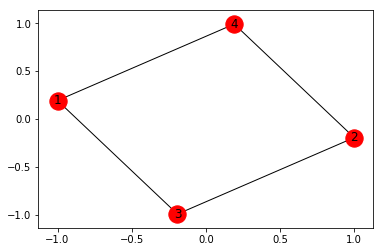

In [147]:
G11 = {1:{3,4}, 2:{3,4}, 3:{1,2}, 4: {1,2}}
draw_graph(G11)

In [189]:
lp_entropy(G8)

{(2, 5): (1, 2, 5), (1, 3): (1, 2, 3), (2, 4): (2, 3, 4), (3, 5): (3, 4, 5), (1, 4): (1, 4, 5)}
[[ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ... -1.  1. -1.]
 [ 0.  0.  0. ...  0. -1.  1.]] (340, 31)
[[-1.  0.  0. ...  0.  0. -1.]
 [-1.  0.  0. ... -1.  0.  0.]
 [-1.  0.  0. ...  0. -1.  0.]
 ...
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]] (340, 31)
340
[[-1.  0.  0. ...  0.  0. -1.]
 [-1.  0.  0. ... -1.  0.  0.]
 [-1.  0.  0. ...  0. -1.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  1.]] (345, 31)
(1,) 1.0
(1, 2) 1.5
(1, 2, 3) 2.0
(1, 2, 3, 4) 2.5
(1, 2, 3, 4, 5) 2.5
(1, 2, 3, 5) 2.5
(1, 2, 4) 2.5
(1, 2, 4, 5) 2.5
(1, 2, 5) 2.0
(1, 3) 2.0
(1, 3, 4) 2.5
(1, 3, 4, 5) 2.5
(1, 3, 5) 2.5
(1, 4) 2.0
(1, 4, 5) 2.0
(1, 5) 1.5
(2,) 1.0
(2, 3) 1.5
(2, 3, 4) 2.0
(2, 3, 4, 5) 2.5
(2, 3, 5) 2.5
(2, 

     con: array([0., 0., 0., 0., 0.])
     fun: -2.5
 message: 'Optimization terminated successfully.'
     nit: 414
   slack: array([0.5, 0. , 0.5, 0.5, 0.5, 0. , 1. , 0.5, 1. , 1. , 0.5, 0.5, 0. ,
       0.5, 0.5, 0.5, 0.5, 0.5, 0. , 0. , 1. , 0.5, 1. , 0.5, 0.5, 0. ,
       0.5, 0. , 1. , 0.5, 0.5, 0.5, 1. , 0.5, 0.5, 0. , 1.5, 0.5, 1. ,
       0.5, 0.5, 0.5, 1. , 2. , 1. , 0.5, 0.5, 1. , 1.5, 0.5, 0.5, 0. ,
       0. , 0.5, 0.5, 0. , 0. , 1. , 1. , 0. , 0.5, 0.5, 1. , 0.5, 0.5,
       1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0.5, 1. ,
       1. , 0. , 0.5, 0.5, 0. , 0.5, 0.5, 1. , 0.5, 0. , 0.5, 0.5, 1. ,
       0.5, 0. , 0.5, 0.5, 1. , 0.5, 1. , 0.5, 1. , 0. , 0.5, 0.5, 1. ,
       0.5, 0.5, 0. , 0.5, 1. , 0.5, 1. , 0.5, 0.5, 0. , 0.5, 0.5, 0.5,
       0. , 0.5, 0.5, 0. , 0. , 0.5, 0. , 0.5, 0. , 1. , 0.5, 0.5, 0. ,
       1.5, 0.5, 0.5, 0. , 0. , 0.5, 0.5, 0. , 0. , 0.5, 1. , 0.5, 0. ,
       0.5, 0.5, 0.5, 0. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 1. ,
       0.

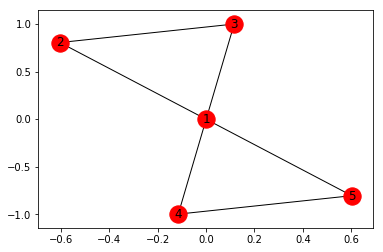

In [149]:
G11 = {1:{2,3,4,5}, 2:{1,3}, 3:{1,2}, 4: {1,5}, 5:{1,4}}
draw_graph(G11)

In [150]:
lp_entropy(G11)

{(2, 3, 4, 5): (1, 2, 3, 4, 5), (1, 3): (1, 2, 3), (1, 2): (1, 2, 3), (1, 5): (1, 4, 5), (1, 4): (1, 4, 5)}
[[ 1.  0. -1. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ... -1.  1. -1.]
 [ 0.  0.  0. ...  0. -1.  1.]] (330, 31)
[[-1.  0.  0. ... -1.  0.  0.]
 [-1.  0.  0. ...  0. -1.  0.]
 [-1.  0.  0. ...  0.  0. -1.]
 ...
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]] (328, 31)
328
[[-1.  0.  0. ... -1.  0.  0.]
 [-1.  0.  0. ...  0. -1.  0.]
 [-1.  0.  0. ...  0.  0. -1.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  1.]] (333, 31)
(1,) 1.0
(1, 2) 2.0
(1, 2, 3) 2.0
(1, 2, 3, 4) 3.0
(1, 2, 3, 4, 5) 3.0
(1, 2, 3, 5) 3.0
(1, 2, 4) 3.0
(1, 2, 4, 5) 3.0
(1, 2, 5) 3.0
(1, 3) 2.0
(1, 3, 4) 3.0
(1, 3, 4, 5) 3.0
(1, 3, 5) 3.0
(1, 4) 2.0
(1, 4, 5) 2.0
(1, 5) 2.0
(2,) 1.0
(2, 3) 1.0
(2, 3, 4) 2.0
(2, 3, 4, 5) 3.0
(2, 3,

     con: array([0., 0., 0., 0., 0.])
     fun: -3.0
 message: 'Optimization terminated successfully.'
     nit: 416
   slack: array([0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 2., 2., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0

In [151]:
import scipy
scipy.optimize.show_options('linprog')



simplex

Minimize a linear objective function subject to linear equality and
non-negativity constraints using the two phase simplex method.
Linear programming is intended to solve problems of the following form:

Minimize::

    c @ x

Subject to::

    A @ x == b
        x >= 0

Parameters
----------
c : 1D array
    Coefficients of the linear objective function to be minimized.
c0 : float
    Constant term in objective function due to fixed (and eliminated)
    variables. (Purely for display.)
A : 2D array
    2D array such that ``A @ x``, gives the values of the equality
    constraints at ``x``.
b : 1D array
    1D array of values representing the right hand side of each equality
    constraint (row) in ``A``.
callback : callable, optional (simplex only)
    If a callback function is provided, it will be called within each
    iteration of the simplex algorithm. The callback must require a
    `scipy.optimize.OptimizeResult` consisting of the following fields:

        x : 1D arr

In [152]:
x = np.array([1., 2., 2., 3., 3., 3., 3., 3., 3., 2., 3., 3., 3., 2., 2., 2., 1.,
       2., 3., 3., 3., 2., 2., 2., 1., 2., 2., 2., 1., 1., 1.])

In [153]:
x.shape[0]

31

# Interesting results

In [154]:
def check_approx_identical_entropy(G1, G2):
    entropy_g1 = lp_entropy(G1)
    entropy_g2 = lp_entropy(G2)
    print(np.round(entropy_g1.x))
    print(np.round(entropy_g2.x))
    return np.array_equal(np.round(entropy_g1.x), np.round(entropy_g2.x))

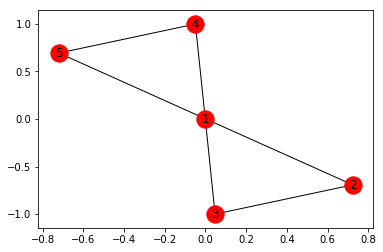

In [155]:
G1 = {1:{2,3,4,5}, 2:{1,3}, 3:{1,2}, 4: {1,5}, 5:{1,4}}
draw_graph(G1)

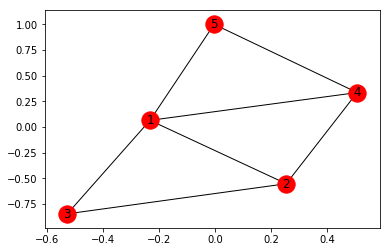

In [156]:
G2 = {1:{2,3,4,5}, 2:{1,3,4}, 3:{1,2}, 4: {1,2,5}, 5:{1,4}}
draw_graph(G2)

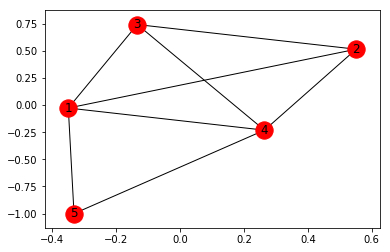

In [157]:
G3 = {1:{2,3,4,5}, 2:{1,3,4}, 3:{1,2,4}, 4: {1,2,3,5}, 5:{1,4}}
draw_graph(G3)

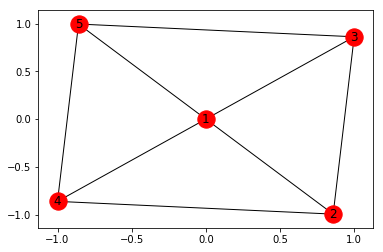

In [158]:
G4 = {1:{2,3,4,5}, 2:{1,3,4}, 3:{1,2,5}, 4: {1,2,5}, 5:{1,3,4}}
draw_graph(G4)

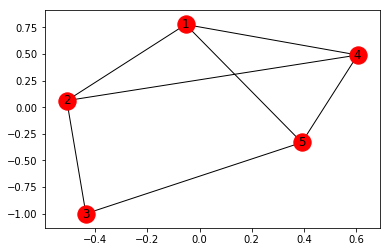

In [159]:
G5 = {1:{2,4,5}, 2:{1,3,4}, 3:{2,5}, 4: {1,2,5}, 5:{1,3,4}}
draw_graph(G5)

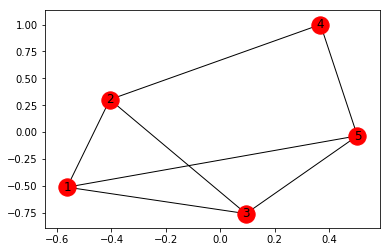

In [160]:
G6 = {1:{2,3,5}, 2:{1,3,4}, 3:{1,2,5}, 4: {2,5}, 5:{1,3,4}}
draw_graph(G6)

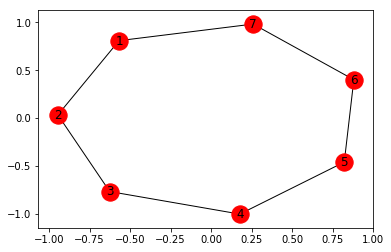

In [165]:
G7 = {1:{2,7}, 2:{1,3}, 3:{2,4}, 4: {3,5}, 5:{4,6}, 6:{5,7}, 7:{1,6}}
draw_graph(G7)

In [166]:
lp_entropy(G7)

{(2, 7): (1, 2, 7), (1, 3): (1, 2, 3), (2, 4): (2, 3, 4), (3, 5): (3, 4, 5), (4, 6): (4, 5, 6), (5, 7): (5, 6, 7), (1, 6): (1, 6, 7)}
[[ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ... -1.  1. -1.]
 [ 0.  0.  0. ...  0. -1.  1.]] (6482, 127)
[[-1.  0.  0. ...  0.  0. -1.]
 [-1.  0.  0. ... -1.  0.  0.]
 [-1.  0.  0. ...  0. -1.  0.]
 ...
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]] (6482, 127)
6482
[[-1.  0.  0. ...  0.  0. -1.]
 [-1.  0.  0. ... -1.  0.  0.]
 [-1.  0.  0. ...  0. -1.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  1.]] (6489, 127)


KeyboardInterrupt: 